# Cache vs Origin comparison

## Data Preparation

In [1]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import Cdf
import Pmf


# define global plot parameters
params = {'axes.labelsize' : 12, 'axes.titlesize' : 12,
          'font.size' : 12, 'legend.fontsize' : 12,
          'xtick.labelsize' : 12, 'ytick.labelsize' : 12}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})


# connect to database
conn = sqlite3.connect('data/youtube-traceroute.db')

# read necessary tables from database
src = pd.read_sql_query('select * from probes_asns', conn)
dst = pd.read_sql_query('select * from dst_asn_mapping', conn)
hostnames = pd.read_sql_query('select * from hostnames', conn)
deltas = pd.read_sql_query('select * from deltas', conn)

conn.close()

# distinguish between IPv4 and IPv6 data
dst_v6 = dst[dst.ip.str.contains(':')]
dst_v4 = dst[~dst.ip.str.contains(':')]

hostnames_v6 = hostnames[hostnames.ip.str.contains(':')]
hostnames_v4 = hostnames[~hostnames.ip.str.contains(':')]


# add ASNs based on probe ASN metadata
deltas = deltas.merge(src, on = 'unit_id')

# add destination ASNs
deltas = deltas.merge(dst_v4, left_on = 'destination_v4', right_on = 'ip').rename(
    columns = {'ip' : 'dst_v4', 'asn' : 'dst_asn_v4', 'holder' : 'dst_holder_v4'})
deltas = deltas.merge(dst_v6, left_on = 'destination_v6', right_on = 'ip').rename(
    columns = {'ip' : 'dst_v6', 'asn' : 'dst_asn_v6', 'holder' : 'dst_holder_v6'})

# add hostnames
deltas = deltas.merge(hostnames_v4, how = 'left', left_on = 'destination_v4', right_on = 'ip').rename(
    columns = {'ip' : 'ip_hostname_v4', 'hostname' : 'hostname_v4'})
deltas = deltas.merge(hostnames_v6, how = 'left', left_on = 'destination_v6', right_on = 'ip').rename(
    columns = {'ip' : 'ip_hostname_v6', 'hostname' : 'hostname_v6'})


# pick correct columns and rearrange order
deltas = deltas[['unit_id', 'dtime',
                 'src_asn_v4', 'src_holder_v4',
                 'dst_v4', 'hostname_v4', 'dst_asn_v4', 'dst_holder_v4',
                 'max(ttl)_v4', 'rtt_v4',
                 'src_asn_v6', 'src_holder_v6',
                 'dst_v6', 'hostname_v6', 'dst_asn_v6', 'dst_holder_v6',
                 'max(ttl)_v6', 'rtt_v6',
                 'ttl_delta', 'rtt_delta']]

## Cache Identification
In this case, a cache is identified by either having the same ASN for source and destination or having one of the following identifiers in its hostname (from reverse DNS lookup):

In [2]:
# to identify caches, use hostname keywords and matching AS numbers for sources and destinations
cache_names = 'ggc|cache'

deltas['is_v4_cache'] = np.where(deltas['hostname_v4'].str.contains(cache_names, na = False) |
                                 (deltas['src_asn_v4'] == deltas['dst_asn_v4']), True, False)
deltas['is_v6_cache'] = np.where(deltas['hostname_v6'].str.contains(cache_names, na = False) |
                                 (deltas['src_asn_v6'] == deltas['dst_asn_v6']), True, False)

v4_cache = deltas.query('is_v4_cache == True')
no_v4_cache = deltas.query('is_v4_cache == False')

v6_cache = deltas.query('is_v6_cache == True')
no_v6_cache = deltas.query('is_v6_cache == False')

In [3]:
# get overview of columns
print(v4_cache.columns)

Index([u'unit_id', u'dtime', u'src_asn_v4', u'src_holder_v4', u'dst_v4',
       u'hostname_v4', u'dst_asn_v4', u'dst_holder_v4', u'max(ttl)_v4',
       u'rtt_v4', u'src_asn_v6', u'src_holder_v6', u'dst_v6', u'hostname_v6',
       u'dst_asn_v6', u'dst_holder_v6', u'max(ttl)_v6', u'rtt_v6',
       u'ttl_delta', u'rtt_delta', u'is_v4_cache', u'is_v6_cache'],
      dtype='object')


# Plotting

In [4]:
# putting related information together for list processing
v4_dfs = [no_v4_cache,
          v4_cache]

v6_dfs = [no_v6_cache,
          v6_cache]

data = [('IPv4', v4_dfs, ['cyan', 'blue']), 
        ('IPv6', v6_dfs, ['orange', 'red'])]

### Plots split out (side by side)

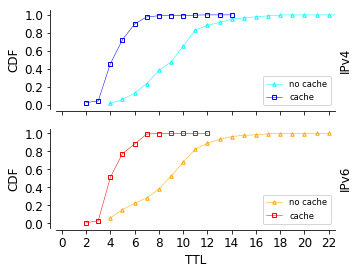

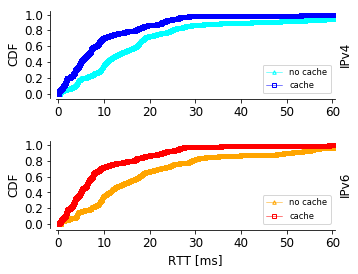

In [5]:
# Side by side plots
ttl_cdf_fig, ttl_cdf_axes = plt.subplots(figsize = (5, 4), nrows = 2, ncols = 1)
rtt_cdf_fig, rtt_cdf_axes = plt.subplots(figsize = (5, 4), nrows = 2, ncols = 1, sharex = True)
plt.subplots_adjust(hspace = 0.5)

# helper variables
i = 0
cdfs = []

# plot loop
for version, dfs, colors in data:

    ### TTL
    ttl_no_cache = Cdf.MakeCdfFromList(dfs[0]['max(ttl)_%s' % version[-2:]])
    ttl_cache = Cdf.MakeCdfFromList(dfs[1]['max(ttl)_%s' % version[-2:]])

    ttl_cdf_axes[i].plot(ttl_no_cache.xs, ttl_no_cache.ps,
                         label = 'no cache',
                         marker = '^',
                         linewidth = 0.5,
                         markersize = 3.5,
                         fillstyle = 'none',
                         color = colors[0])
    ttl_cdf_axes[i].plot(ttl_cache.xs, ttl_cache.ps, label = 'cache', marker = 's', linewidth = 0.5, markersize = 3.5, fillstyle = 'none', color = colors[1])
    
    
    # PLOT FORMATTING
    # customize axes and grid appearance
    ttl_cdf_axes[i].set_ylabel('CDF')
    ttl_cdf_axes[i].set_ylim([-0.05, 1.05])
    ttl_cdf_axes[i].set_xlim([-0.5, 22.5])
    ttl_cdf_axes[i].xaxis.set_ticks(range(0, 23, 2))

    ttl_cdf_axes[i].legend(loc = 'lower right', fontsize = 'smaller')
    
    yticks = np.arange(0.0, 1.01, 0.2)
    ttl_cdf_axes[i].set_yticks(yticks)
    ttl_cdf_axes[i].grid(False)
    ttl_cdf_axes[i].spines['right'].set_color('none')
    ttl_cdf_axes[i].spines['top'].set_color('none')
    ttl_cdf_axes[i].yaxis.set_ticks_position('left')
    ttl_cdf_axes[i].xaxis.set_ticks_position('bottom')
    ttl_cdf_axes[i].spines['bottom'].set_position(('axes', -0.02))
    ttl_cdf_axes[i].spines['left'].set_position(('axes', -0.02))
    
    ax1_ = ttl_cdf_axes[i].twinx()
    ax1_.spines['right'].set_color('none')
    ax1_.spines['top'].set_color('none')
    ax1_.spines['left'].set_color('none')
    ax1_.spines['bottom'].set_color('none')
    ax1_.yaxis.set_ticks_position('none')
    ax1_.set_ylabel('%s' % version)
    plt.setp(ax1_.get_yticklabels(), visible = False)
    


    ### RTT
    rtt_no_cache = Cdf.MakeCdfFromList(dfs[0]['rtt_%s' % version[-2:]])
    rtt_cache = Cdf.MakeCdfFromList(dfs[1]['rtt_%s' % version[-2:]])

    rtt_cdf_axes[i].plot(rtt_no_cache.xs, rtt_no_cache.ps, label = 'no cache', marker = '^', linewidth = 0.5, markersize = 3.5, fillstyle = 'none', color = colors[0])
    rtt_cdf_axes[i].plot(rtt_cache.xs, rtt_cache.ps, label = 'cache', marker = 's', linewidth = 0.5, markersize = 3.5, fillstyle = 'none', color = colors[1])

    
    # PLOT FORMATTING
    # customize axes and grid appearance
    rtt_cdf_axes[i].set_ylabel('CDF')
    rtt_cdf_axes[i].set_ylim([-0.05, 1.05])
    rtt_cdf_axes[i].minorticks_off()
    rtt_cdf_axes[i].set_xscale('log')

    rtt_cdf_axes[i].legend(loc = 'lower right', fontsize = 'smaller')

    yticks = np.arange(0.0, 1.01, 0.2)
    rtt_cdf_axes[i].set_yticks(yticks)
    rtt_cdf_axes[i].grid(False)
    rtt_cdf_axes[i].spines['right'].set_color('none')
    rtt_cdf_axes[i].spines['top'].set_color('none')
    rtt_cdf_axes[i].yaxis.set_ticks_position('left')
    rtt_cdf_axes[i].xaxis.set_ticks_position('bottom')
    rtt_cdf_axes[i].spines['bottom'].set_position(('axes', -0.02))
    rtt_cdf_axes[i].spines['left'].set_position(('axes', -0.02))
    
    ax1_ = rtt_cdf_axes[i].twinx()
    ax1_.spines['right'].set_color('none')
    ax1_.spines['top'].set_color('none')
    ax1_.spines['left'].set_color('none')
    ax1_.spines['bottom'].set_color('none')
    ax1_.yaxis.set_ticks_position('none')
    ax1_.set_ylabel('%s' % version)
    plt.setp(ax1_.get_yticklabels(), visible = False)
    
    
    # adjust x-axis based on what metric we are looking at
    if i == 0:
        ttl_cdf_axes[i].set_xlabel('')
        rtt_cdf_axes[i].set_xlabel('')
        ttl_cdf_axes[i].set_xticklabels([])
        rtt_cdf_axes[i].set_xticklabels([])
    else:
        ttl_cdf_axes[i].set_xlabel('TTL')
        rtt_cdf_axes[i].set_xlabel('RTT [ms]')
    
    # increase helper variable to go to correct data/plot in next iteration
    i = i + 1
    
    # append calculated CDFs to list for later use
    cdfs.append(ttl_no_cache)
    cdfs.append(ttl_cache)
    cdfs.append(rtt_no_cache)
    cdfs.append(rtt_cache)

    
# get "zoomed in version" of rtt
rtt_cdf_axes[0].set_xscale('linear')
rtt_cdf_axes[0].set_xlim([-0.5, 60.5])
rtt_cdf_axes[1].set_xscale('linear')
rtt_cdf_axes[1].set_xlim([-0.5, 60.5])

#ttl_cdf_fig.savefig('plots/cache_nocache_ttl.pdf', bbox_inches = 'tight')
#rtt_cdf_fig.savefig('plots/cache_nocache_rtt.pdf', bbox_inches = 'tight')
plt.show()

### TTL and RTT in one plot each

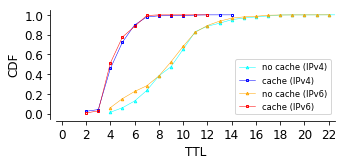

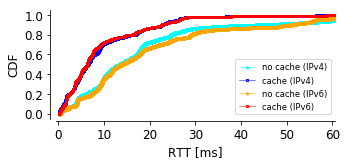

In [6]:
# in one plot
ttl_cdf_fig, ttl_cdf_ax = plt.subplots(figsize = (5, 2))
rtt_cdf_fig, rtt_cdf_ax = plt.subplots(figsize = (5, 2))
plt.subplots_adjust(hspace = 0.5)

# plot loop
for version, dfs, colors in data:

    ### TTL
    ttl_no_cache = Cdf.MakeCdfFromList(dfs[0]['max(ttl)_%s' % version[-2:]])
    ttl_cache = Cdf.MakeCdfFromList(dfs[1]['max(ttl)_%s' % version[-2:]])

    ### RTT
    rtt_no_cache = Cdf.MakeCdfFromList(dfs[0]['rtt_%s' % version[-2:]])
    rtt_cache = Cdf.MakeCdfFromList(dfs[1]['rtt_%s' % version[-2:]])

    ttl_cdf_ax.plot(ttl_no_cache.xs, ttl_no_cache.ps,
                    label = 'no cache (%s)' % version,
                    marker = '^', linewidth = 0.5,
                    markersize = 2.5,
                    fillstyle = 'none',
                    color = colors[0])
    rtt_cdf_ax.plot(rtt_no_cache.xs, rtt_no_cache.ps,
                    label = 'no cache (%s)' % version,
                    marker = '^', linewidth = 0.5,
                    markersize = 2.5,
                    fillstyle = 'none',
                    color = colors[0])
    ttl_cdf_ax.plot(ttl_cache.xs, ttl_cache.ps,
                    label = 'cache (%s)' % version,
                    marker = 's', linewidth = 0.5,
                    markersize = 2.5,
                    fillstyle = 'none',
                    color = colors[1])
    rtt_cdf_ax.plot(rtt_cache.xs, rtt_cache.ps,
                    label = 'cache (%s)' % version,
                    marker = 's',
                    linewidth = 0.5,
                    markersize = 2.5,
                    fillstyle = 'none',
                    color = colors[1])

# PLOT FORMATTING
# customize axes and grid appearance
ttl_cdf_ax.set_ylabel('CDF')
ttl_cdf_ax.set_ylim([-0.05, 1.05])
ttl_cdf_ax.set_xlim([-0.5, 22.5])
ttl_cdf_ax.xaxis.set_ticks(range(0, 23, 2))

ttl_cdf_ax.legend(loc = 'lower right', fontsize = 'smaller')

yticks = np.arange(0.0, 1.01, 0.2)
ttl_cdf_ax.set_yticks(yticks)
ttl_cdf_ax.grid(False)
ttl_cdf_ax.spines['right'].set_color('none')
ttl_cdf_ax.spines['top'].set_color('none')
ttl_cdf_ax.yaxis.set_ticks_position('left')
ttl_cdf_ax.xaxis.set_ticks_position('bottom')
ttl_cdf_ax.spines['bottom'].set_position(('axes', -0.02))
ttl_cdf_ax.spines['left'].set_position(('axes', -0.02))    


### RTT

# PLOT FORMATTING
# customize axes and grid appearance
rtt_cdf_ax.set_ylabel('CDF')
rtt_cdf_ax.set_ylim([-0.05, 1.05])
rtt_cdf_ax.minorticks_off()
rtt_cdf_ax.set_xscale('log')

rtt_cdf_ax.legend(loc = 'lower right', fontsize = 'smaller')

yticks = np.arange(0.0, 1.01, 0.2)
rtt_cdf_ax.set_yticks(yticks)
rtt_cdf_ax.grid(False)
rtt_cdf_ax.spines['right'].set_color('none')
rtt_cdf_ax.spines['top'].set_color('none')
rtt_cdf_ax.yaxis.set_ticks_position('left')
rtt_cdf_ax.xaxis.set_ticks_position('bottom')
rtt_cdf_ax.spines['bottom'].set_position(('axes', -0.02))
rtt_cdf_ax.spines['left'].set_position(('axes', -0.02))    

# adjust x-axis based on what metric we are looking at
ttl_cdf_ax.set_xlabel('TTL')
rtt_cdf_ax.set_xlabel('RTT [ms]')

# get "zoomed in version" of rtt
rtt_cdf_ax.set_xscale('linear')
rtt_cdf_ax.set_xlim([-0.5, 60.5])
rtt_cdf_ax.set_xscale('linear')
rtt_cdf_ax.set_xlim([-0.5, 60.5])


# saving and showing plots
ttl_cdf_fig.savefig('plots/combined_cache_nocache_ttl.pdf', bbox_inches = 'tight')
rtt_cdf_fig.savefig('plots/combined_cache_nocache_rtt.pdf', bbox_inches = 'tight')
plt.show()

## Distributions of metrics for all cases

In [7]:
# "cdfs" contains:
#    - v4 TTL no cache
#    - v4 TTL w/ cache

#    - v4 RTT no cache
#    - v4 RTT w/ cache

#    - v6 TTL no cache
#    - v6 TTL w/ cache

#    - v6 RTT no cache
#    - v6 RTT w/ cache

info = zip(['ttl_v4_no_cache', 'ttl_v4_cache',
        'rtt_v4_no_cache', 'rtt_v4_cache',
        'ttl_v6_no_cache', 'ttl_v6_cache',
        'rtt_v6_no_cache', 'rtt_v6_cache'], cdfs)

In [8]:
for name, cdf in info:
    
    print('--- %s ---' % name)
    print('value; cdf')
    print('')
    
    if len(cdf.xs) > 100:
        tup = list(zip(cdf.xs, cdf.ps))[0::200]
    else:
        tup = zip(cdf.xs, cdf.ps)
    
    for x, y in tup:
        print('%.2f; %.5f' % (x, y))
        
    print('\n')

--- ttl_v4_no_cache ---
value; cdf

4.00; 0.01454
5.00; 0.06030
6.00; 0.12833
7.00; 0.23515
8.00; 0.38299
9.00; 0.47531
10.00; 0.65216
11.00; 0.83013
12.00; 0.88533
13.00; 0.91516
14.00; 0.95114
15.00; 0.96770
16.00; 0.97926
17.00; 0.98924
18.00; 0.99856
19.00; 0.99935
20.00; 0.99940
21.00; 0.99944
22.00; 0.99997
23.00; 1.00000


--- ttl_v4_cache ---
value; cdf

2.00; 0.02410
3.00; 0.04154
4.00; 0.45734
5.00; 0.72450
6.00; 0.89859
7.00; 0.97802
8.00; 0.99044
9.00; 0.99111
10.00; 0.99248
11.00; 0.99776
12.00; 0.99982
13.00; 0.99984
14.00; 1.00000


--- rtt_v4_no_cache ---
value; cdf

0.41; 0.00000
0.64; 0.03888
1.10; 0.04318
1.36; 0.04774
1.64; 0.05276
1.89; 0.05622
2.17; 0.05974
2.44; 0.06275
2.65; 0.07126
2.85; 0.07534
3.06; 0.07872
3.26; 0.08242
3.46; 0.08563
3.67; 0.09341
3.87; 0.10871
4.07; 0.13017
4.27; 0.15056
4.48; 0.16643
4.73; 0.16993
4.94; 0.18576
5.14; 0.19241
5.40; 0.19421
5.61; 0.19743
5.82; 0.20008
6.07; 0.20177
6.28; 0.20926
6.49; 0.21287
6.69; 0.21902
6.89; 0.22658
7.10